In [1]:
# Working with AIA and XRT data in python to get the DEM via regularisation

# Now looking at some of the 28 Sep 2018 data
# 17-06-2021 IGH -> Based off ax_sep2020_new

In [2]:
# Import some of the stuff we might need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import scipy.io as io
#  Using demreg from https://github.com/ianan/demreg/tree/master/python
from dn2dem_pos import dn2dem_pos
import glob

import astropy.time
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [3]:
# Load in the XRT data and grade map for the Sep 2018 data from sswidl make_xrt_for_python.pro

fdata='XRT_20180928_204303_Be_thin_Open_512.fits'
fgm='gm_XRT_20180928_204303_Be_thin_Open_512.fits'

xmap=sunpy.map.Map(fdata)
xgmmap=sunpy.map.Map(fgm)


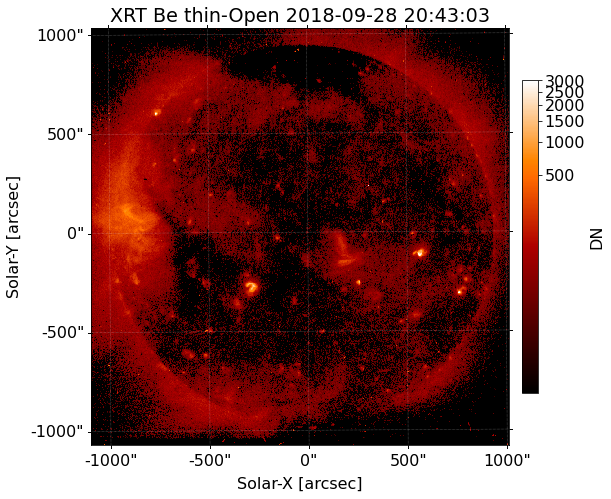

In [4]:
#  Plot the map to check looks ok
dmin=3
dmax=3e3

fig = plt.figure(figsize=(8, 8))
xmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()


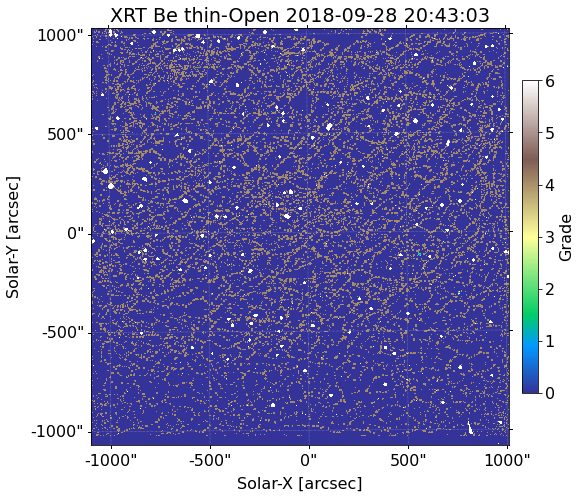

In [5]:
# Plot the grade map
fig = plt.figure(figsize=(8, 8))
xgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()

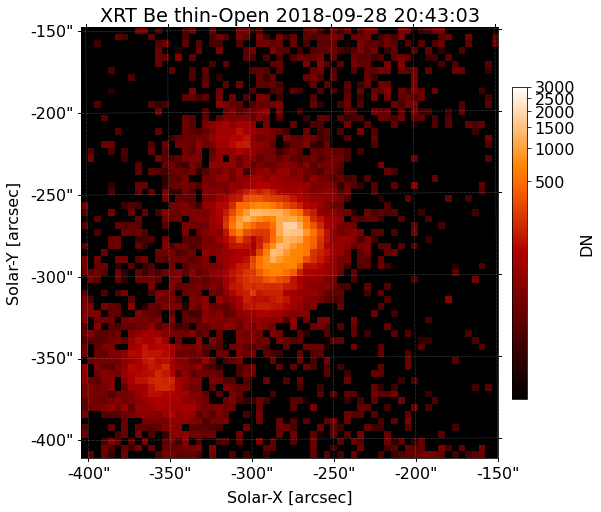

In [6]:
# Submap closer to the region of interest
bl=[-400*u.arcsec, -410*u.arcsec]
tr=[-150*u.arcsec, -150*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
sxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
sxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

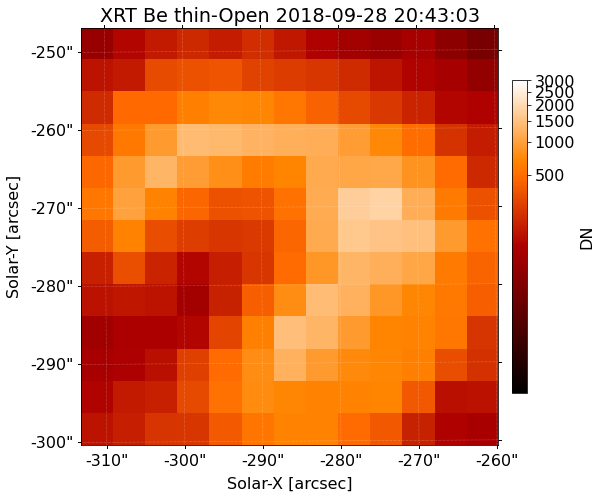

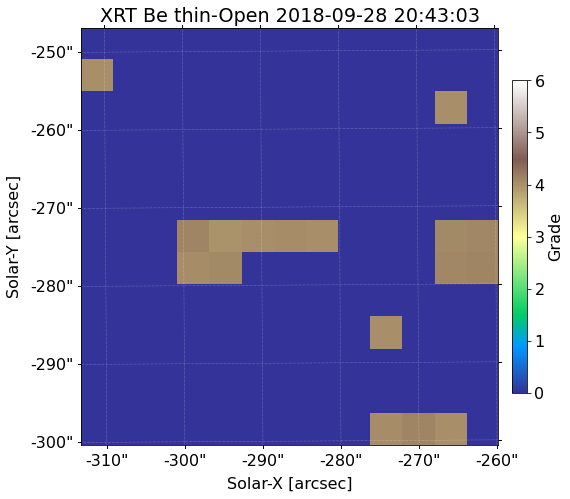

In [7]:
#  Get the XRT for just the region of interest
bl=[-310*u.arcsec, -300*u.arcsec]
tr=[-260*u.arcsec, -250*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
regxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
regxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

# Same for the grade map showing some grade 4 near feature => contamination spots
regxgmmap = xgmmap.submap(bottom_left=bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8, 8))
regxgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()


In [8]:
#  What is the DN/s/px from the region???
dur=regxmap.exposure_time.value
# What pixel binning per dimension
chipsum=regxmap.meta['chip_sum']
#  Get a DN/s/px (non-binned pixels) for the region
xdnspx=np.mean(regxmap.data)/dur/chipsum**2
print(xdnspx, ' DN/s/px')

1.9605031779332698  DN/s/px


In [9]:
# # # Get the AIA data
# from sunpy.net import Fido
# from sunpy.net import attrs as a
# result = Fido.search(a.Time('2018/09/28 20:43:00', '2018/09/28 20:43:11'),
#                      a.Instrument.aia)
# # result
# Fido.fetch(result,path='.')

In [10]:
# # #  Now prep and get the AIA values
# # #  Do all the prep first and save out the submaps
# ffa=sorted(glob.glob('aia_lev1*2018_09_28*.fits'))
# # print(ffa)

# amaps=sunpy.map.Map(ffa)
# # Get the wavelengths of the maps, get index of sort for this list of maps and reorder
# wvn0 = [m.meta['wavelnth'] for m in amaps]
# srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
# amaps = [amaps[i] for i in srt_id]
# print([m.meta['wavelnth'] for m in amaps])

# # aiaprep the images, may take a while to run
# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m)
#     aprep.append(register(m_temp))
# #  Just save out the prepped submaps to quickly load in later
# for m in aprep:
#     bottom_left = SkyCoord(-380*u.arcsec,-340*u.arcsec, frame=m.coordinate_frame)
#     top_right = SkyCoord(-220*u.arcsec,-200*u.arcsec, frame=m.coordinate_frame)
#     mm = m.submap(bottom_left=bottom_left, top_right=top_right)
#     wvn="{0:d}".format(1000+mm.meta['wavelnth'])
#     wvn=wvn[1:]
#     mm.save('maps_prep_092018_'+wvn+'.fits',overwrite='True')



In [11]:
ffp=sorted(glob.glob('maps_prep_092018*.fits'))
aprep=sunpy.map.Map(ffp)

In [12]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
durs = [m.meta['exptime'] for m in aprep]
# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.902056 2.901323 2.000159 2.000051 2.900769 2.900805]
[ 94 131 171 193 211 335]


1.3140625e+19


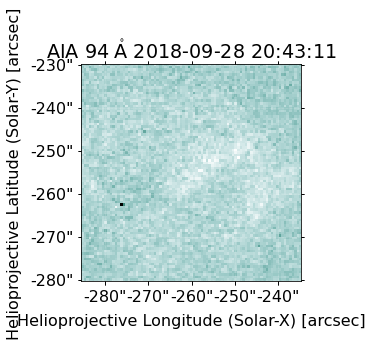

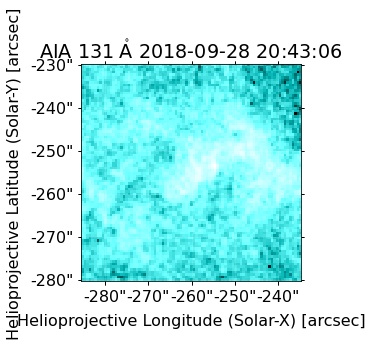

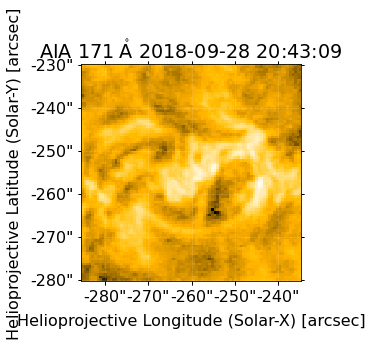

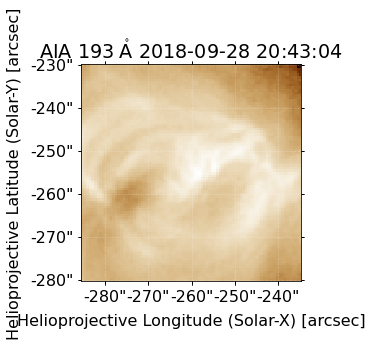

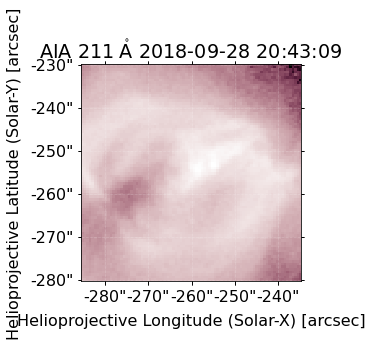

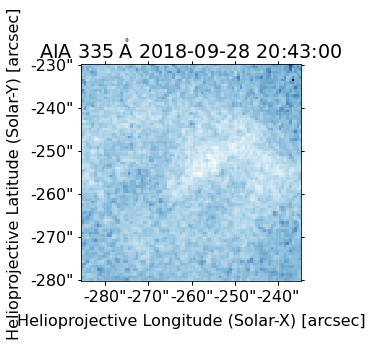

[3.8376477, 14.154058955276552, 282.08898645868237, 613.794473111726, 274.02673829542675, 3.956252477269253]


In [13]:
# Same size region as XRT, but slight offset (due to XRT pointing?)
# NOTE: These are just rough regions to check the process and DEM calculation is working....
bl=[-285*u.arcsec, -280*u.arcsec]
tr=[-235*u.arcsec, -230*u.arcsec]

area=(tr[0].value-bl[0].value)*(tr[1].value-bl[1].value)*7.25e7*7.25e7  
print(area)

data_mean = []
num_pix = []
for m in aprep:
    bottom_left = SkyCoord(bl[0],bl[1], frame = m.coordinate_frame)
    top_right = SkyCoord(tr[0],tr[1], frame=m.coordinate_frame)
    sub_temp = m.submap(bottom_left=bottom_left, top_right=top_right)
    data_mean.append(np.mean(sub_temp.data))
    num_pix.append(sub_temp.data.size)
    sub_temp.plot()
    plt.show()
print(data_mean)

In [14]:
# # Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=astropy.time.Time('2018-09-28T20:43:00', scale='utc')

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time)#,calibration_version=10)
# print(degs)

# # As slow to compute here's the previously calculated for the above
degs=np.array([0.90317732, 0.51622918, 0.73993289, 0.62176348, 0.58117789, 0.19292336])
print(degs)

[0.90317732 0.51622918 0.73993289 0.62176348 0.58117789 0.19292336]


In [15]:
#  Correct the AIA data for the degradation
cor_data=data_mean/degs
print(data_mean)
print(cor_data)

# Get into DN/s/px for the DEM stuff
adn_in=cor_data/durs
print('DN/s/px: ',adn_in)

[3.8376477, 14.154058955276552, 282.08898645868237, 613.794473111726, 274.02673829542675, 3.956252477269253]
[  4.24905231  27.41816911 381.23590703 987.18321815 471.50234551
  20.50686074]
DN/s/px:  [  1.46415242   9.45022981 190.60280059 493.57902281 162.54391353
   7.06936893]


In [16]:
#  Load in the AIA responses from sswidl make_aiaresp_forpy.pro
trin=io.readsav('aia_tresp_en.dat')

for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
# print(trin['channels'])
chans=np.array(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,7))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [17]:
#  Load in the XRT ones from sswidl make_xrt_tresp_forpy.pro
tr_sep20=io.readsav('xrt_tresp_20180928.dat')

filters=np.array(tr_sep20['filters'])
filters[0]=filters[0].decode('utf-8')
filters[1]=filters[1].decode('utf-8')
# print(filters)
units=tr_sep20['units'].decode('utf-8')

In [18]:
#  Combine the AIA and XRT together
chanax=np.append(chans,filters[1])
print(chanax)
xtrint=10**np.interp(tresp_logt,tr_sep20['logt'],np.log10(tr_sep20['tr'][1]))
trmatrix[:,6]=xtrint

['A94' 'A131' 'A171' 'A193' 'A211' 'A335' 'Be-thin']


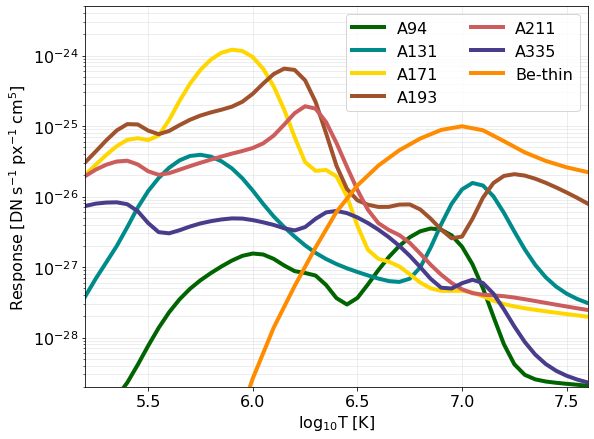

In [19]:
# Setup some colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','darkorange']

# Do the plot
fig = plt.figure(figsize=(9, 7))
for i in np.arange(7):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=chanax[i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.2,7.6])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

In [20]:
# Now combine the AIA and XRT data together
dn_in=np.append(adn_in,xdnspx)
print(dn_in)
# Lets just assume some % error
edn_in=0.1*np.copy(dn_in)
print(edn_in)

[  1.46415242   9.45022981 190.60280059 493.57902281 162.54391353
   7.06936893   1.96050318]
[ 0.14641524  0.94502298 19.06028006 49.35790228 16.25439135  0.70693689
  0.19605032]


In [21]:
# What temperature binning do we want for the DEM ?
temps=np.logspace(5.6,6.8,num=42)
dt=([temps[i+1]-temps[i] for i in np.arange(0,len(temps)-1)])
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

chisq [A]:  1.1956054994382754
dn_reg/dn_in [A]:  [0.96585826 0.80028267 1.03559938 0.86658865 0.93329507 0.91533474]
chisq [AX]:  13.512431881381305
dn_reg/dn_in [AX]:  [0.5169025  0.51671552 0.79531792 0.62032262 0.65021229 0.58852903
 1.03483785]


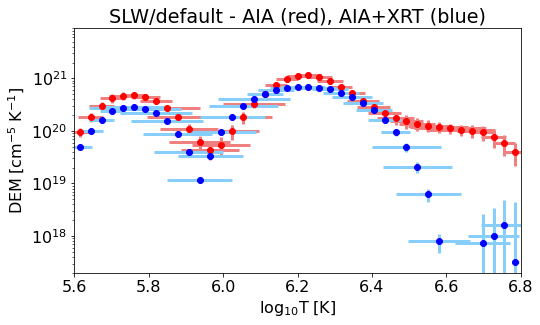

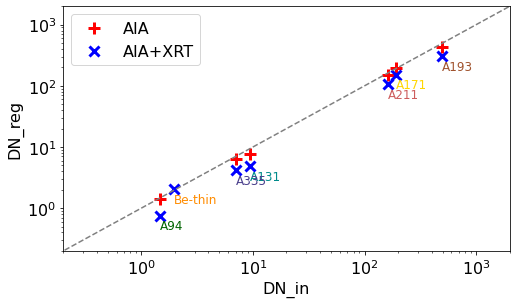

In [22]:
# Using newly updated demregpy, it can do the Lweighting for you -> self-weighted, emloci min or user
# Start by just using the self-weighted version - which is the default
# Trying here AIA only, the AIA+XRT

# AIA only
dema,edema,elogta,chisqa,dn_rega\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps)
# AIA + XRT 
demax,edemax,elogtax,chisqax,dn_regax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)

print('chisq [A]: ',chisqa)
print('dn_reg/dn_in [A]: ',dn_rega/dn_in[0:6])
print('chisq [AX]: ',chisqax)
print('dn_reg/dn_in [AX]: ',dn_regax/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dema,xerr=elogta,yerr=edema,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.title('SLW/default - AIA (red), AIA+XRT (blue)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in[0:6],dn_rega,color='red',marker='+',s=150,lw=3,label='AIA')
plt.scatter(dn_in,dn_regax,color='blue',marker='x',s=100,lw=3,label='AIA+XRT')
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in[i], 0.6*dn_regax[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

chisq [A]:  0.9741721156771784
dn_reg/dn_in [A]:  [0.99294232 0.85141502 1.05062962 0.84119245 0.9094386  0.98160282]
chisq [AX]:  7.792015383249473
dn_reg/dn_in [AX]:  [0.60346895 0.69050423 1.08711167 0.72264715 0.73150846 0.63242963
 1.02660534]


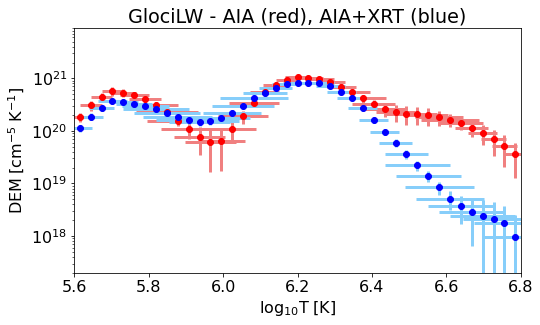

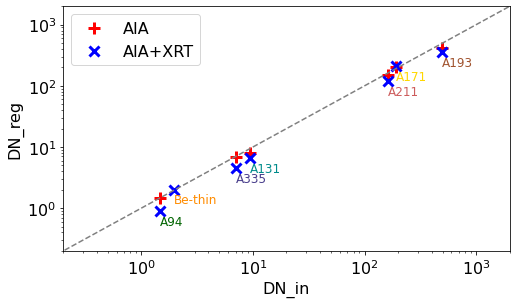

In [23]:
#  Now do the EM Loci weigthed L with AIA and AIA+XRT
# AIA only
dema,edema,elogta,chisqa,dn_rega\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps,gloci=1)
# AIA + XRT 
demax,edemax,elogtax,chisqax,dn_regax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)

print('chisq [A]: ',chisqa)
print('dn_reg/dn_in [A]: ',dn_rega/dn_in[0:6])
print('chisq [AX]: ',chisqax)
print('dn_reg/dn_in [AX]: ',dn_regax/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dema,xerr=elogta,yerr=edema,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.title('GlociLW - AIA (red), AIA+XRT (blue)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in[0:6],dn_rega,color='red',marker='+',s=150,lw=3,label='AIA')
plt.scatter(dn_in,dn_regax,color='blue',marker='x',s=100,lw=3,label='AIA+XRT')
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in[i], 0.6*dn_regax[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()



chisq [AX]:  7.792015383249473
dn_reg/dn_in [AX]:  [0.60346895 0.69050423 1.08711167 0.72264715 0.73150846 0.63242963
 1.02660534]
chisq [AX2]:  15.499539272399616
dn_reg/dn_in [AX2]:  [0.48356609 0.60881723 1.02629954 0.59759271 0.54275522 0.45851436
 1.01835783]


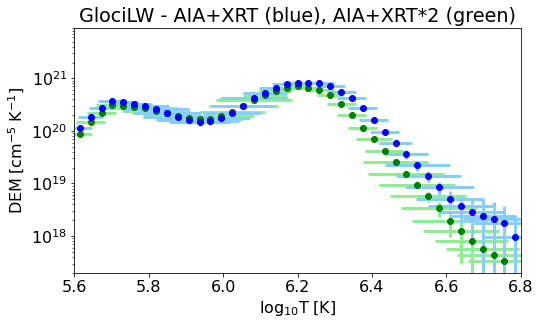

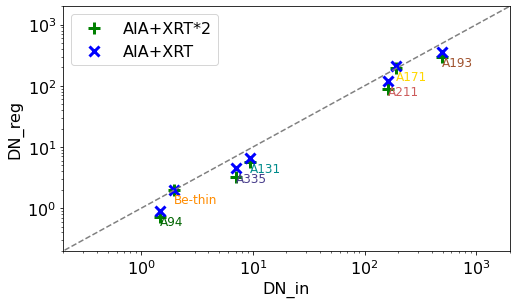

In [24]:
# Now try it with the XRT response*2
# Wright et al. 2017 and Schmelz et al. 2015 did this via factor x2-3 of the XRT temperature response
# i.e. https://iopscience.iop.org/article/10.3847/1538-4357/aa7a59#apjaa7a59f8

# In this form this does not seem to help
# Maybe need to be better with the input uncertainties, as very weak signals here.

trm2=np.copy(trmatrix)
#  Multiply the XRT response by 2
trm2[:,6]=trm2[:,6]*2.0

# AIA + XRT*2 
demax2,edemax2,elogtax2,chisqax2,dn_regax2\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps,gloci=1)

print('chisq [AX]: ',chisqax)
print('dn_reg/dn_in [AX]: ',dn_regax/dn_in)
print('chisq [AX2]: ',chisqax2)
print('dn_reg/dn_in [AX2]: ',dn_regax2/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,demax2,xerr=elogtax2,yerr=edemax2,fmt='og',\
             ecolor='lightgreen', elinewidth=3, capsize=0)
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.title('GlociLW - AIA+XRT (blue), AIA+XRT*2 (green)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in,dn_regax2,color='green',marker='+',s=150,lw=3,label='AIA+XRT*2')
plt.scatter(dn_in,dn_regax,color='blue',marker='x',s=100,lw=3,label='AIA+XRT')
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in[i], 0.6*dn_regax[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# So again in this case it seems to make things worse again over the bigger T range?


chisq [AX68]:  7.792015383249473
dn_reg/dn_in [AX68]:  [0.60346895 0.69050423 1.08711167 0.72264715 0.73150846 0.63242963
 1.02660534]
chisq [AX65]:  1.643120240560386
dn_reg/dn_in [AX65]:  [0.75599699 0.87789962 1.09572234 0.9660106  1.01459312 0.82885708
 1.02741427]


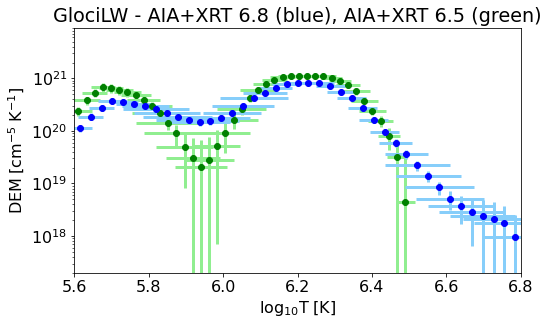

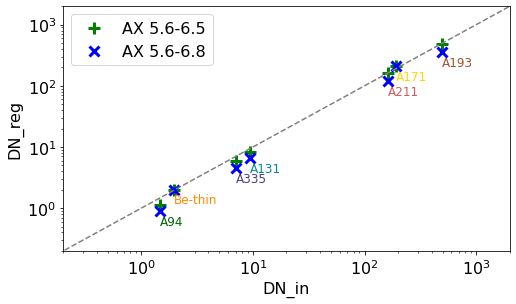

In [25]:
# Try with a different temperature binning -> lower upper T from 6.8 to 6.5
# Back to using just the original XRT response as well
temps2=np.logspace(5.6,6.5,num=42)
dt2=([temps2[i+1]-temps2[i] for i in np.arange(0,len(temps2)-1)])
mlogt2=([np.mean([(np.log10(temps2[i])),np.log10((temps2[i+1]))]) \
        for i in np.arange(0,len(temps2)-1)])

demax65,edemax65,elogtax65,chisqax65,dn_regax65\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps2,gloci=1)

print('chisq [AX68]: ',chisqax)
print('dn_reg/dn_in [AX68]: ',dn_regax/dn_in)
print('chisq [AX65]: ',chisqax65)
print('dn_reg/dn_in [AX65]: ',dn_regax65/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt2,demax65,xerr=elogtax65,yerr=edemax65,fmt='og',\
             ecolor='lightgreen', elinewidth=3, capsize=0)
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.title('GlociLW - AIA+XRT 6.8 (blue), AIA+XRT 6.5 (green)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in,dn_regax65,color='green',marker='+',s=150,lw=3,label='AX 5.6-6.5')
plt.scatter(dn_in,dn_regax,color='blue',marker='x',s=100,lw=3,label='AX 5.6-6.8')
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in[i], 0.6*dn_regax[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# Better if we restrict the DEM upper T range


chisq [AX10%]:  7.792015383249473
dn_reg/dn_in [AX10%]:  [0.60346895 0.69050423 1.08711167 0.72264715 0.73150846 0.63242963
 1.02660534]
chisq [AX20%]:  1.488100341775935
dn_reg/dn_in [AX20%]:  [0.63687294 0.72400513 1.10563427 0.7757327  0.79293778 0.67806561
 1.0257437 ]


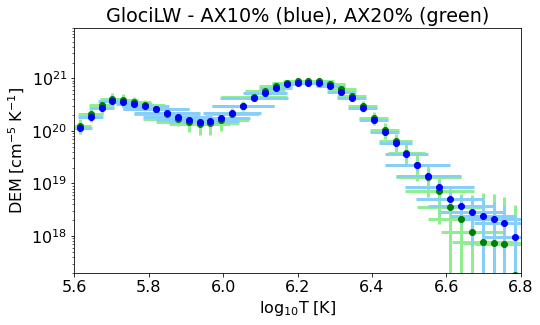

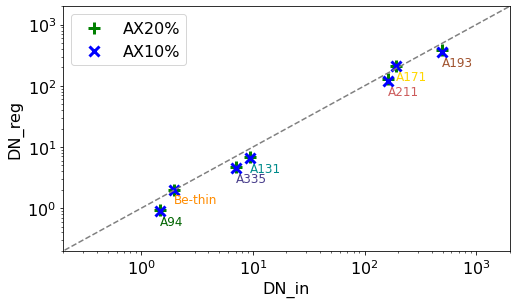

In [26]:
# Another thing to try is making the systmatic uncertainty bigger, above using 10%
demax10,edemax10,elogtax10,chisqax10,dn_regax10\
    =dn2dem_pos(dn_in,0.1*np.copy(dn_in),trmatrix,tresp_logt,temps,gloci=1)
#  Now do 20% as well
demax20,edemax20,elogtax20,chisqax20,dn_regax20\
    =dn2dem_pos(dn_in,0.2*np.copy(dn_in),trmatrix,tresp_logt,temps,gloci=1)


print('chisq [AX10%]: ',chisqax10)
print('dn_reg/dn_in [AX10%]: ',dn_regax10/dn_in)
print('chisq [AX20%]: ',chisqax20)
print('dn_reg/dn_in [AX20%]: ',dn_regax20/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,demax20,xerr=elogtax20,yerr=edemax20,fmt='og',\
             ecolor='lightgreen', elinewidth=3, capsize=0)
plt.errorbar(mlogt,demax10,xerr=elogtax10,yerr=edemax10,fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.title('GlociLW - AX10% (blue), AX20% (green)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in,dn_regax20,color='green',marker='+',s=150,lw=3,label='AX20%')
plt.scatter(dn_in,dn_regax10,color='blue',marker='x',s=100,lw=3,label='AX10%')
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in[i], 0.6*dn_regax[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()


In [27]:
# Maybe something to do with the uncertainties -> so far just been using a 10%, 20% systematic
print('94: ',data_mean[0],'DN/px, ',num_pix[0],' pixels')
# AIA photon couting errors
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])

# Original DN/px value uncorrected from the AIA maps * num_pix to get original DN
aia_dn_org=np.array(data_mean)*np.array(num_pix)
aia_edn_org=(dn2ph*aia_dn_org)**0.5/dn2ph

print('shotnoise [%]: ',100.*aia_edn_org/aia_dn_org)
# print(data_mean[0],num_pix[0])
# So as averaging over larger area the AIA shotnoise (and other?) components small rel to systematics?

# Above just considering shotnoise, other components from sswidl code
# From https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/idl/response/aia_bp_estimate_error.pro
# 
# Try 94 as likely to be the noisest channel
# IDL> a=aia_bp_estimate_error(3.8376477,94,n_sample=7140,/loud) ;input/output in DN/px
#  Counts [DN]   RMS Error      SNR     Shot     Dark     Read    Quant Compress  Chianti Calibrat
#         3.84        0.18    20.92     0.03     0.18     0.01     0.00     0.00     0.00     0.00

# Main other ones:
# Dark is 0.18 irrespective of n_sample
# Readout is 1.15 / sqrt(n_sample)
# Quantum is 0.288819 / sqrt(n_sample)
# Noise terms given in DN, so to get DN/px need factor sqrt(n_sample)/n_sample = 1/sqrt(n_sample)

# So shotnoise the same (as it should be), and total slightly bigger overall but << systematics.

# Hopefully aiapy version will be available soon https://gitlab.com/LMSAL_HUB/aia_hub/aiapy/-/issues/60


94:  3.8376477 DN/px,  7140  pixels
shotnoise [%]:  [0.84893931 0.3818266  0.07464847 0.04684713 0.06705566 0.45162495]


In [28]:
# For XRT uncertainty estimate can use 
# https://hesperia.gsfc.nasa.gov/ssw/hinode/xrt/idl/response/j/xrt_cvfact.pro
# 
# In sswidl for Be-thin at time of obs
# IDL> te = 5.+findgen(61)*0.05
# IDL> cf = xrt_cvfact(te, 3, 0, '12-Sep-2020 20:40:00', /error)
# IDL> DN = 100.
# IDL> print, 'noise [DN]: ',sqrt(DN*cf)
# 
# Though this returns array as function of T, so not sure how to use this....
# Nothing similar for XRT as aia_bp_error_estimate.pro